In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch.optim.lr_scheduler as sched
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from utils import plot_sparsity_matrix,weight_histograms,set_all_seeds, plot_weight_histograms
from dataset import get_mnist_loader
from pruning import sparsity_prune_module, count_nonzero_weights
from train import training_loop, evaluate
from models.lenet import LeNet5,LeNet300
from quantization import cluster_quantize

import datetime
import numpy as np

# Introduction
This notebook studies the Deep Compression process, described in the paper "Deep Compression: compressing deep neural networks with pruning, trained quantization and Huffman Coding, Song Han et al., 2016." [[1](#1)]
Here we replicate the results of the paper using MNIST dataset, using the LeNet-300-100 and LeNet-5 models [[2](#2)].

# Configuration

In [2]:
BATCH_SIZE = 128
EPOCHS = 20
LR = 1e-3
WD = 1e-3

S1 = 0.92
S2 = 0.91
S3 = 0.74

BITS = 6

SEED = 42
SPLIT = 0.1
CLASSES = list(range(0,10))
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Try to get GPU device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

checkpoint_path = '../checkpoints/'
set_all_seeds(SEED)

train_loader, valid_loader, test_loader = get_mnist_loader(BATCH_SIZE,num_workers=1,val_split=SPLIT,resize=False)

Print images from dataset and their labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 1, 28, 28]) torch.Size([128])
7 9 7 1


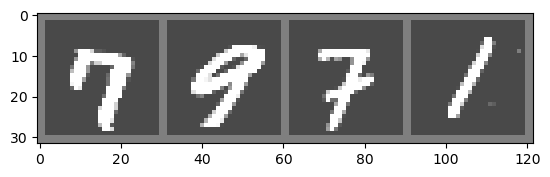

In [3]:
import matplotlib.pyplot as plt
from utils import imshow

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join(f'{labels[j]:1d}' for j in range(4)))

# LeNet-300-100

LeNet-300-100 is a Fully-Connected neural network, presented in [[2](#2)].
It is composed by two hidden layers, with respectively 300 and 100 units.

Differently from the original implementation, we employ ReLU activation instead of tanh, and we use a softmax over the last layer logits to calculate the predictions and a negative log likelihood loss.

In [4]:
from models.lenet import LeNet300

net = LeNet300(10)

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(DEVICE)
net.to(DEVICE)

cuda:0


LeNet300(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

In [5]:
loss_fn = F.cross_entropy
optimizer = optim.AdamW(net.parameters(), lr=LR, weight_decay=WD)

## Learning connections

In [6]:
writer = SummaryWriter('../runs/notebooks/lenet300-100-base/%s' % TIMESTAMP)

train_acc, val_acc = training_loop(EPOCHS,net,optimizer,DEVICE,train_loader,valid_loader,loss_fn,100,
                                         None,'../checkpoints/mnist-lenet300-100.pth',writer)

writer.add_hparams({'epochs':EPOCHS,'learning rate':LR,'weight decay':WD},{'train_accuracy':train_acc,'validation accuracy':val_acc,'compression':1})
writer.add_scalar('total parameters',count_nonzero_weights(net))

500it [00:12, 39.21it/s, acc1=91.3, acc5=99.3, batch=400, loss=0.294]                         


Epoch: 001/020 | Train accuracy: 91.54% | Validation accuracy: 96.27% | Train loss: 0.287| Validation loss: 0.123| Best Validation (Ep. 001): 96.27%


500it [00:11, 43.36it/s, acc1=96.6, acc5=99.9, batch=400, loss=0.112]                         


Epoch: 002/020 | Train accuracy: 96.61% | Validation accuracy: 97.40% | Train loss: 0.112| Validation loss: 0.088| Best Validation (Ep. 002): 97.40%


500it [00:11, 44.17it/s, acc1=97.7, acc5=100, batch=400, loss=0.074]                          


Epoch: 003/020 | Train accuracy: 97.69% | Validation accuracy: 97.80% | Train loss: 0.074| Validation loss: 0.077| Best Validation (Ep. 003): 97.80%


500it [00:11, 44.07it/s, acc1=98.3, acc5=100, batch=400, loss=0.0527]                         


Epoch: 004/020 | Train accuracy: 98.31% | Validation accuracy: 98.02% | Train loss: 0.053| Validation loss: 0.069| Best Validation (Ep. 004): 98.02%


500it [00:11, 44.12it/s, acc1=98.7, acc5=100, batch=400, loss=0.0403]                         


Epoch: 005/020 | Train accuracy: 98.67% | Validation accuracy: 97.90% | Train loss: 0.041| Validation loss: 0.074| Best Validation (Ep. 004): 98.02%


500it [00:11, 44.20it/s, acc1=99, acc5=100, batch=400, loss=0.0317]                           


Epoch: 006/020 | Train accuracy: 98.98% | Validation accuracy: 98.12% | Train loss: 0.032| Validation loss: 0.069| Best Validation (Ep. 006): 98.12%


500it [00:11, 43.98it/s, acc1=99.1, acc5=100, batch=400, loss=0.0267]                         


Epoch: 007/020 | Train accuracy: 99.09% | Validation accuracy: 98.23% | Train loss: 0.027| Validation loss: 0.071| Best Validation (Ep. 007): 98.23%


500it [00:11, 43.94it/s, acc1=99.3, acc5=100, batch=400, loss=0.0214]                         


Epoch: 008/020 | Train accuracy: 99.26% | Validation accuracy: 97.97% | Train loss: 0.021| Validation loss: 0.081| Best Validation (Ep. 007): 98.23%


500it [00:11, 44.37it/s, acc1=99.3, acc5=100, batch=400, loss=0.0194]                         


Epoch: 009/020 | Train accuracy: 99.33% | Validation accuracy: 98.32% | Train loss: 0.019| Validation loss: 0.075| Best Validation (Ep. 009): 98.32%


500it [00:11, 44.27it/s, acc1=99.4, acc5=100, batch=400, loss=0.0183]                         


Epoch: 010/020 | Train accuracy: 99.34% | Validation accuracy: 97.83% | Train loss: 0.019| Validation loss: 0.086| Best Validation (Ep. 009): 98.32%


500it [00:11, 43.98it/s, acc1=99.4, acc5=100, batch=400, loss=0.0162]                         


Epoch: 011/020 | Train accuracy: 99.44% | Validation accuracy: 98.37% | Train loss: 0.016| Validation loss: 0.078| Best Validation (Ep. 011): 98.37%


500it [00:11, 44.14it/s, acc1=99.5, acc5=100, batch=400, loss=0.0144]                         


Epoch: 012/020 | Train accuracy: 99.51% | Validation accuracy: 98.17% | Train loss: 0.015| Validation loss: 0.087| Best Validation (Ep. 011): 98.37%


500it [00:11, 44.22it/s, acc1=99.6, acc5=100, batch=400, loss=0.0109]                          


Epoch: 013/020 | Train accuracy: 99.62% | Validation accuracy: 97.73% | Train loss: 0.011| Validation loss: 0.108| Best Validation (Ep. 011): 98.37%


500it [00:11, 44.14it/s, acc1=99.6, acc5=100, batch=400, loss=0.0116]                          


Epoch: 014/020 | Train accuracy: 99.63% | Validation accuracy: 97.95% | Train loss: 0.012| Validation loss: 0.107| Best Validation (Ep. 011): 98.37%


500it [00:11, 43.79it/s, acc1=99.5, acc5=100, batch=400, loss=0.0145]                          


Epoch: 015/020 | Train accuracy: 99.51% | Validation accuracy: 98.03% | Train loss: 0.015| Validation loss: 0.089| Best Validation (Ep. 011): 98.37%


500it [00:11, 44.29it/s, acc1=99.6, acc5=100, batch=400, loss=0.0116]                          


Epoch: 016/020 | Train accuracy: 99.62% | Validation accuracy: 98.25% | Train loss: 0.011| Validation loss: 0.083| Best Validation (Ep. 011): 98.37%


500it [00:11, 42.18it/s, acc1=99.7, acc5=100, batch=400, loss=0.00922]                         


Epoch: 017/020 | Train accuracy: 99.69% | Validation accuracy: 98.12% | Train loss: 0.009| Validation loss: 0.102| Best Validation (Ep. 011): 98.37%


500it [00:13, 37.44it/s, acc1=99.7, acc5=100, batch=400, loss=0.0107]                          


Epoch: 018/020 | Train accuracy: 99.65% | Validation accuracy: 98.12% | Train loss: 0.011| Validation loss: 0.102| Best Validation (Ep. 011): 98.37%


500it [00:12, 38.60it/s, acc1=99.7, acc5=100, batch=400, loss=0.00928]                         


Epoch: 019/020 | Train accuracy: 99.68% | Validation accuracy: 98.20% | Train loss: 0.009| Validation loss: 0.100| Best Validation (Ep. 011): 98.37%


500it [00:11, 43.08it/s, acc1=99.7, acc5=100, batch=400, loss=0.00835]                         


Epoch: 020/020 | Train accuracy: 99.70% | Validation accuracy: 98.38% | Train loss: 0.009| Validation loss: 0.088| Best Validation (Ep. 020): 98.38%
Total Training Time: 4.79 min


The error rate on the validation set is 1.5%, which is slightly worse than what declared in the paper and in the original article of LeCun et al. , 1998.

## Pruning

*** Pruning 92% of weights for layer weight
*** Pruned 216384 weights (92.000 %)
*** Pruning 91% of weights for layer weight
*** Pruned 27300 weights (91.000 %)
*** Pruning 74% of weights for layer weight
*** Pruned 740 weights (74.000 %)
Total compression factor: 12.2 (8.18% retained weights) | top-1 Accuracy after pruning: 88.067%


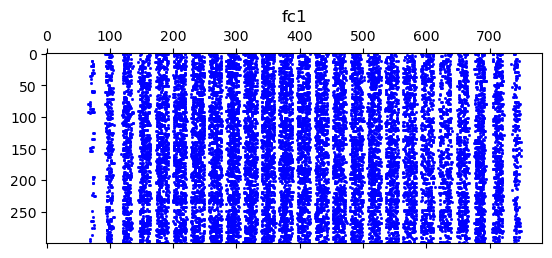

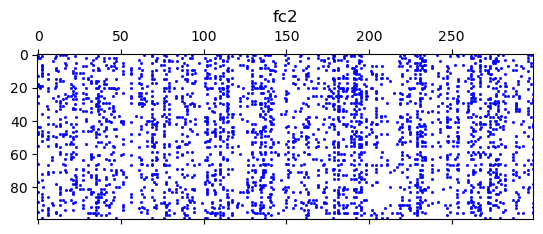

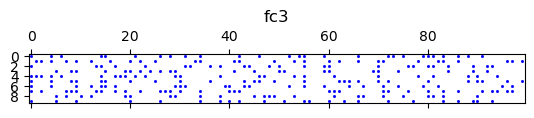

In [7]:
# reload checkpoint
net = LeNet300(10).to(DEVICE)
net.load_state_dict(torch.load('../checkpoints/mnist-lenet300-100.pth'))

# prune each layer using a different sparsity level
fc1_pruned, _ = sparsity_prune_module(net.fc1,'weight',S1)
fc2_pruned, _ = sparsity_prune_module(net.fc2,'weight',S2)
fc3_pruned, _ = sparsity_prune_module(net.fc3,'weight',S3)
writer = SummaryWriter('../runs/notebooks/lenet300-100-pruned/%s' % TIMESTAMP)

total_weights = count_nonzero_weights(net)
compression = total_weights / (total_weights-(fc1_pruned+fc2_pruned+fc3_pruned))

# evaluate accuracy after pruning
loss, acc1, acc5 = evaluate(net,valid_loader,DEVICE,loss_fn)

print('Total compression factor: %.1f (%.2f%% retained weights) | top-1 Accuracy after pruning: %.3f%%' % (
        compression,1/compression*100,acc1))

writer.add_hparams({'epochs':EPOCHS,'learning rate':LR,'weight decay':WD},{'validation accuracy':acc1,'compression':compression})

plot_sparsity_matrix(net)
torch.save(net.state_dict(),'../checkpoints/mnist-lenet300-100-pruned.pth')

We can see that the fc1 layer is divided in 28 vertical bands, whose width is 28, corresponding to the $28 \times 28$ input pixel.
As stated in [[2](#2)], network pruning detects visual attention regions: the colored regions, correspond to non-zero parameters, are more dense in the center of the image, since the digits are written in the center.

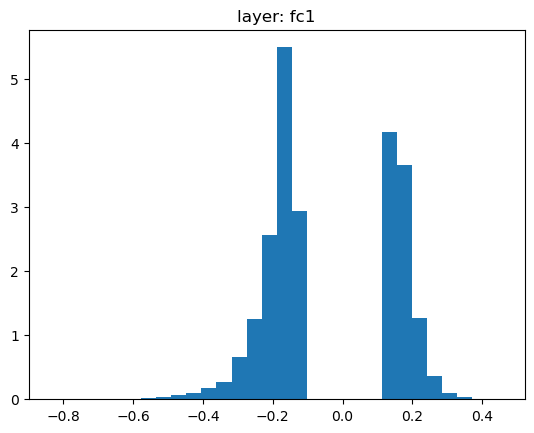

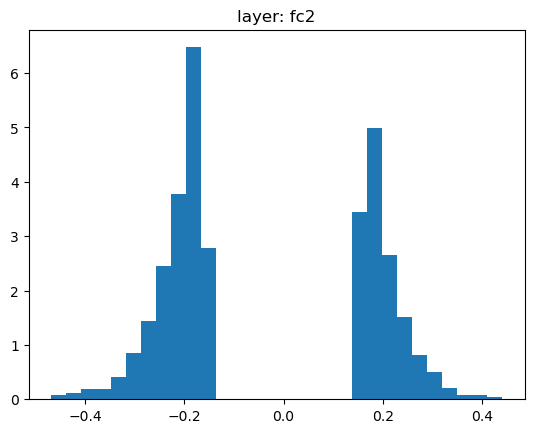

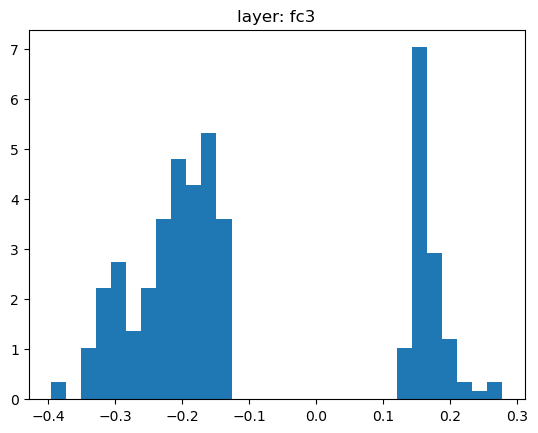

In [8]:
plot_weight_histograms(net)

Pruned weights follow a bimodal distribution

500it [00:12, 40.43it/s, acc1=97.9, acc5=100, batch=400, loss=0.0755]                          


Epoch: 001/020 | Train accuracy: 97.98% | Validation accuracy: 97.97% | Train loss: 0.073| Validation loss: 0.068| Best Validation (Ep. 001): 97.97%


500it [00:11, 44.32it/s, acc1=99.2, acc5=100, batch=400, loss=0.0261]                         


Epoch: 002/020 | Train accuracy: 99.23% | Validation accuracy: 98.10% | Train loss: 0.026| Validation loss: 0.065| Best Validation (Ep. 002): 98.10%


500it [00:11, 43.93it/s, acc1=99.6, acc5=100, batch=400, loss=0.0162]                         


Epoch: 003/020 | Train accuracy: 99.58% | Validation accuracy: 98.20% | Train loss: 0.016| Validation loss: 0.064| Best Validation (Ep. 003): 98.20%


500it [00:11, 43.27it/s, acc1=99.8, acc5=100, batch=400, loss=0.0107]                         


Epoch: 004/020 | Train accuracy: 99.77% | Validation accuracy: 98.24% | Train loss: 0.011| Validation loss: 0.064| Best Validation (Ep. 004): 98.24%


500it [00:11, 45.20it/s, acc1=99.9, acc5=100, batch=400, loss=0.00718]                         


Epoch: 005/020 | Train accuracy: 99.89% | Validation accuracy: 98.31% | Train loss: 0.007| Validation loss: 0.064| Best Validation (Ep. 005): 98.31%


500it [00:11, 44.81it/s, acc1=99.9, acc5=100, batch=400, loss=0.005]                           


Epoch: 006/020 | Train accuracy: 99.94% | Validation accuracy: 98.34% | Train loss: 0.005| Validation loss: 0.069| Best Validation (Ep. 006): 98.34%


500it [00:11, 44.70it/s, acc1=100, acc5=100, batch=400, loss=0.00334]                         


Epoch: 007/020 | Train accuracy: 99.97% | Validation accuracy: 98.37% | Train loss: 0.003| Validation loss: 0.072| Best Validation (Ep. 007): 98.37%


500it [00:12, 39.63it/s, acc1=100, acc5=100, batch=400, loss=0.00227]                         


Epoch: 008/020 | Train accuracy: 99.99% | Validation accuracy: 98.38% | Train loss: 0.002| Validation loss: 0.073| Best Validation (Ep. 008): 98.38%


500it [00:11, 45.07it/s, acc1=100, acc5=100, batch=400, loss=0.0016]                          


Epoch: 009/020 | Train accuracy: 100.00% | Validation accuracy: 98.27% | Train loss: 0.002| Validation loss: 0.077| Best Validation (Ep. 008): 98.38%


500it [00:11, 44.62it/s, acc1=100, acc5=100, batch=400, loss=0.00114]                         


Epoch: 010/020 | Train accuracy: 100.00% | Validation accuracy: 98.29% | Train loss: 0.001| Validation loss: 0.080| Best Validation (Ep. 008): 98.38%


500it [00:11, 44.95it/s, acc1=100, acc5=100, batch=400, loss=0.000853]                         


Epoch: 011/020 | Train accuracy: 100.00% | Validation accuracy: 98.29% | Train loss: 0.001| Validation loss: 0.081| Best Validation (Ep. 008): 98.38%


500it [00:19, 25.54it/s, acc1=100, acc5=100, batch=400, loss=0.00062]                          


Epoch: 012/020 | Train accuracy: 100.00% | Validation accuracy: 98.30% | Train loss: 0.001| Validation loss: 0.083| Best Validation (Ep. 008): 98.38%


500it [00:11, 43.40it/s, acc1=100, acc5=100, batch=400, loss=0.000469]                         


Epoch: 013/020 | Train accuracy: 100.00% | Validation accuracy: 98.31% | Train loss: 0.000| Validation loss: 0.086| Best Validation (Ep. 008): 98.38%


500it [00:11, 45.31it/s, acc1=100, acc5=100, batch=400, loss=0.000357]                         


Epoch: 014/020 | Train accuracy: 100.00% | Validation accuracy: 98.34% | Train loss: 0.000| Validation loss: 0.089| Best Validation (Ep. 008): 98.38%


500it [00:10, 45.55it/s, acc1=100, acc5=100, batch=400, loss=0.000268]                         


Epoch: 015/020 | Train accuracy: 100.00% | Validation accuracy: 98.28% | Train loss: 0.000| Validation loss: 0.091| Best Validation (Ep. 008): 98.38%


500it [00:10, 45.92it/s, acc1=100, acc5=100, batch=400, loss=0.000207]                         


Epoch: 016/020 | Train accuracy: 100.00% | Validation accuracy: 98.28% | Train loss: 0.000| Validation loss: 0.094| Best Validation (Ep. 008): 98.38%


500it [00:11, 44.44it/s, acc1=100, acc5=100, batch=400, loss=0.000158]                         


Epoch: 017/020 | Train accuracy: 100.00% | Validation accuracy: 98.31% | Train loss: 0.000| Validation loss: 0.095| Best Validation (Ep. 008): 98.38%


500it [00:11, 43.98it/s, acc1=100, acc5=100, batch=400, loss=0.000123]                         


Epoch: 018/020 | Train accuracy: 100.00% | Validation accuracy: 98.33% | Train loss: 0.000| Validation loss: 0.098| Best Validation (Ep. 008): 98.38%


500it [00:11, 44.26it/s, acc1=100, acc5=100, batch=400, loss=9.48e-5]                         


Epoch: 019/020 | Train accuracy: 100.00% | Validation accuracy: 98.35% | Train loss: 0.000| Validation loss: 0.100| Best Validation (Ep. 008): 98.38%


500it [00:11, 44.05it/s, acc1=100, acc5=100, batch=400, loss=7.6e-5]                          


Epoch: 020/020 | Train accuracy: 100.00% | Validation accuracy: 98.31% | Train loss: 0.000| Validation loss: 0.102| Best Validation (Ep. 008): 98.38%
Total Training Time: 5.01 min


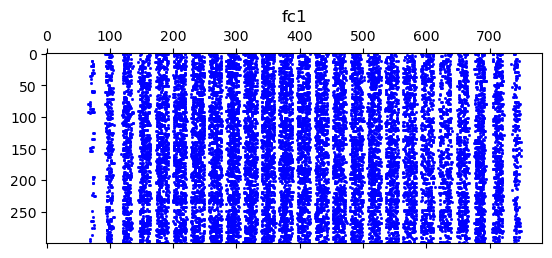

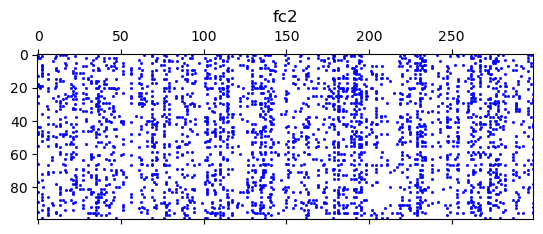

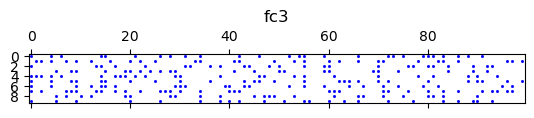

In [9]:
from train import evaluate

writer = SummaryWriter('../runs/notebooks/mnist-lenet300-100-finetuned/%s' % TIMESTAMP)
optimizer = optim.AdamW(net.parameters(),lr=LR,weight_decay=WD)

train_acc, val_acc = training_loop(EPOCHS,net,optimizer,DEVICE,train_loader,test_loader,loss_fn,100,
                                         None,'../checkpoints/mnist-lenet300-100-retrained.pth',writer)

writer.add_hparams({'epochs':EPOCHS,'learning rate':LR,'weight decay':WD},{'train_accuracy':train_acc,'validation accuracy':val_acc,'compression':compression})

plot_sparsity_matrix(net)

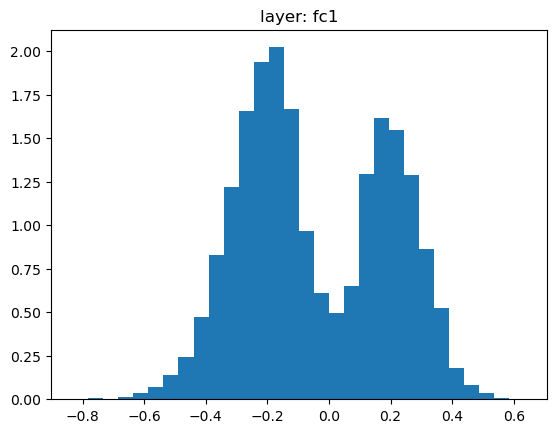

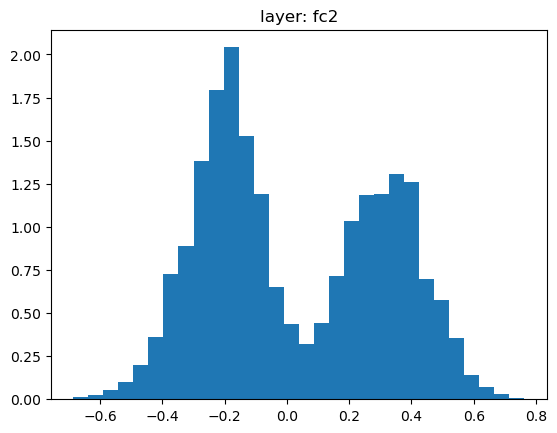

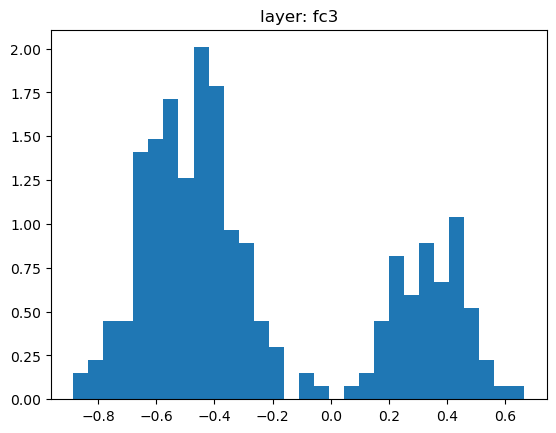

In [10]:
plot_weight_histograms(net)

## Quantization

In [ ]:
net.to('cpu')

for name,module in net.named_modules():
    if isinstance(module,nn.Linear):
        cluster_quantize(module,'weight',BITS)

net.to(DEVICE)

optimizer = optim.AdamW(net.parameters(), lr=LR, weight_decay=WD)
# scheduler = sched.StepLR(optimizer,DECAY_STEPS,GAMMA)

writer = SummaryWriter('../runs/notebooks/lenet300-100-quantized/%s' % TIMESTAMP)

train_acc, val_acc = training_loop(20,net,optimizer,DEVICE,train_loader,valid_loader,loss_fn,100,
                                         writer=writer)

In [ ]:
plot_weight_histograms(net)

## Huffman encoding

# LeNet-5

![Lenet5](./../assets/lenet-5_1.jpg "LeNet 5")

The input is a $32 \times 32$ image, since [[2](#2)] found desirable to have distinctive features of each character in the center of the receptive field of the highest-level feature detectors.

- C1 is a convolutional layer with 6 feature maps and a kernel of $5 \times 5$.
- S

Images need to be rescaled to size 32x32 as described in LeCun et al. 1998

In [4]:
S1 = .34
S2 = .88
S3 = .92
S4 = .81

# Load datasets
train_loader,valid_loader,test_loader = get_mnist_loader(BATCH_SIZE,num_workers=1,val_split=SPLIT,resize=True)
loss_fn = F.cross_entropy

In [7]:
net = LeNet5(10)
optimizer = optim.AdamW(net.parameters(), lr=LR,weight_decay=WD)
# lrs = MyMultiStepLR({0:5e-4,2:2e-4,5:1e-4,8:5e-5,12:1e-5})
# scheduler = sched.LambdaLR(optimizer,  lrs.get_lr,last_epoch=-1,verbose=True)
net.to(DEVICE)

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

## Learning connections

In [8]:
writer = SummaryWriter('../runs/notebooks/lenet-5-base/%s' % TIMESTAMP)

train_acc, val_acc = training_loop(EPOCHS,net,optimizer,DEVICE,train_loader,test_loader,loss_fn,100,None
                                         ,'../checkpoints/mnist-lenet5.pth',writer)

writer.add_hparams({'epochs':EPOCHS,'learning rate':LR,'weight decay':WD},{'train_accuracy':train_acc,'validation accuracy':val_acc,'compression':1})
writer.add_scalar('total parameters',count_nonzero_weights(net))


500it [00:21, 23.31it/s, acc1=91, acc5=98.7, batch=400, loss=0.309]                           


Epoch: 001/020 | Train accuracy: 91.24% | Validation accuracy: 96.13% | Train loss: 0.300| Validation loss: 0.119| Best Validation (Ep. 001): 96.13%


500it [00:14, 34.95it/s, acc1=97.3, acc5=99.9, batch=400, loss=0.0893]                         


Epoch: 002/020 | Train accuracy: 97.32% | Validation accuracy: 97.95% | Train loss: 0.090| Validation loss: 0.063| Best Validation (Ep. 002): 97.95%


500it [00:14, 35.08it/s, acc1=98.1, acc5=100, batch=400, loss=0.0622]                         


Epoch: 003/020 | Train accuracy: 98.06% | Validation accuracy: 98.16% | Train loss: 0.062| Validation loss: 0.055| Best Validation (Ep. 003): 98.16%


500it [00:14, 35.49it/s, acc1=98.4, acc5=100, batch=400, loss=0.0509]                         


Epoch: 004/020 | Train accuracy: 98.39% | Validation accuracy: 98.86% | Train loss: 0.051| Validation loss: 0.037| Best Validation (Ep. 004): 98.86%


500it [00:14, 35.20it/s, acc1=98.7, acc5=100, batch=400, loss=0.0416]                         


Epoch: 005/020 | Train accuracy: 98.68% | Validation accuracy: 98.87% | Train loss: 0.042| Validation loss: 0.034| Best Validation (Ep. 005): 98.87%


500it [00:14, 35.15it/s, acc1=98.9, acc5=100, batch=400, loss=0.0345]                         


Epoch: 006/020 | Train accuracy: 98.92% | Validation accuracy: 98.76% | Train loss: 0.034| Validation loss: 0.041| Best Validation (Ep. 005): 98.87%


500it [00:14, 35.15it/s, acc1=99.1, acc5=100, batch=400, loss=0.029]                          


Epoch: 007/020 | Train accuracy: 99.06% | Validation accuracy: 98.86% | Train loss: 0.029| Validation loss: 0.035| Best Validation (Ep. 005): 98.87%


500it [00:14, 35.50it/s, acc1=99.2, acc5=100, batch=400, loss=0.0251]                         


Epoch: 008/020 | Train accuracy: 99.19% | Validation accuracy: 99.11% | Train loss: 0.025| Validation loss: 0.031| Best Validation (Ep. 008): 99.11%


500it [00:14, 35.52it/s, acc1=99.3, acc5=100, batch=400, loss=0.0211]                         


Epoch: 009/020 | Train accuracy: 99.32% | Validation accuracy: 99.06% | Train loss: 0.021| Validation loss: 0.029| Best Validation (Ep. 008): 99.11%


500it [00:14, 35.26it/s, acc1=99.3, acc5=100, batch=400, loss=0.0213]                         


Epoch: 010/020 | Train accuracy: 99.32% | Validation accuracy: 99.08% | Train loss: 0.021| Validation loss: 0.031| Best Validation (Ep. 008): 99.11%


500it [00:14, 35.57it/s, acc1=99.5, acc5=100, batch=400, loss=0.0169]                         


Epoch: 011/020 | Train accuracy: 99.45% | Validation accuracy: 98.94% | Train loss: 0.017| Validation loss: 0.035| Best Validation (Ep. 008): 99.11%


500it [00:14, 35.70it/s, acc1=99.5, acc5=100, batch=400, loss=0.0154]                         


Epoch: 012/020 | Train accuracy: 99.50% | Validation accuracy: 98.93% | Train loss: 0.015| Validation loss: 0.033| Best Validation (Ep. 008): 99.11%


500it [00:14, 34.99it/s, acc1=99.5, acc5=100, batch=400, loss=0.0158]                         


Epoch: 013/020 | Train accuracy: 99.49% | Validation accuracy: 99.06% | Train loss: 0.016| Validation loss: 0.030| Best Validation (Ep. 008): 99.11%


500it [00:14, 34.99it/s, acc1=99.6, acc5=100, batch=400, loss=0.0133]                         


Epoch: 014/020 | Train accuracy: 99.57% | Validation accuracy: 99.06% | Train loss: 0.013| Validation loss: 0.031| Best Validation (Ep. 008): 99.11%


500it [00:14, 35.02it/s, acc1=99.6, acc5=100, batch=400, loss=0.0117]                          


Epoch: 015/020 | Train accuracy: 99.61% | Validation accuracy: 98.98% | Train loss: 0.012| Validation loss: 0.036| Best Validation (Ep. 008): 99.11%


500it [00:14, 35.56it/s, acc1=99.7, acc5=100, batch=400, loss=0.00991]                         


Epoch: 016/020 | Train accuracy: 99.65% | Validation accuracy: 99.08% | Train loss: 0.010| Validation loss: 0.033| Best Validation (Ep. 008): 99.11%


500it [00:14, 35.40it/s, acc1=99.7, acc5=100, batch=400, loss=0.00763]                         


Epoch: 017/020 | Train accuracy: 99.72% | Validation accuracy: 99.09% | Train loss: 0.008| Validation loss: 0.036| Best Validation (Ep. 008): 99.11%


500it [00:14, 35.43it/s, acc1=99.8, acc5=100, batch=400, loss=0.00725]                         


Epoch: 018/020 | Train accuracy: 99.71% | Validation accuracy: 98.72% | Train loss: 0.009| Validation loss: 0.046| Best Validation (Ep. 008): 99.11%


500it [00:14, 35.48it/s, acc1=99.7, acc5=100, batch=400, loss=0.0101]                          


Epoch: 019/020 | Train accuracy: 99.67% | Validation accuracy: 98.86% | Train loss: 0.010| Validation loss: 0.044| Best Validation (Ep. 008): 99.11%


500it [00:14, 35.32it/s, acc1=99.7, acc5=100, batch=400, loss=0.00869]                         


Epoch: 020/020 | Train accuracy: 99.73% | Validation accuracy: 99.01% | Train loss: 0.008| Validation loss: 0.042| Best Validation (Ep. 008): 99.11%
Total Training Time: 6.12 min


## Pruning

*** Pruning 34% of weights for layer weight
*** Pruned 2 weights (33.333 %)
*** Pruning 88% of weights for layer weight
*** Pruned 14 weights (87.500 %)
*** Pruning 92% of weights for layer weight
*** Pruned 44160 weights (92.000 %)
*** Pruning 81% of weights for layer weight
*** Pruned 8165 weights (81.002 %)
Total compression factor: 6.7 (14.91% retained weights) | top-1 Accuracy after pruning: 37.167%


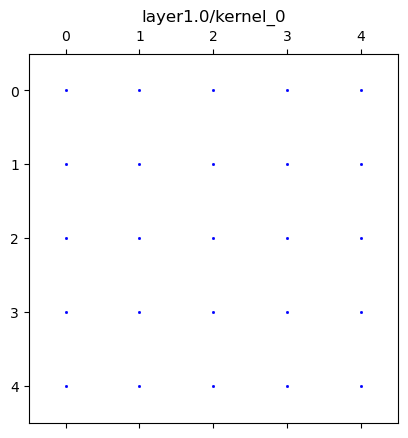

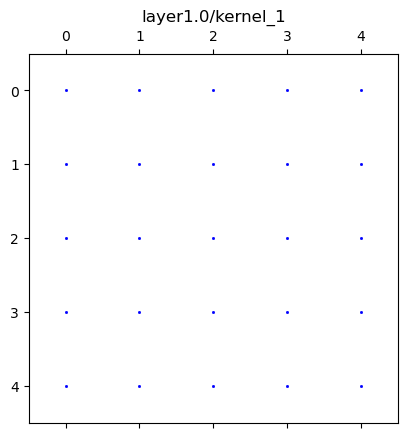

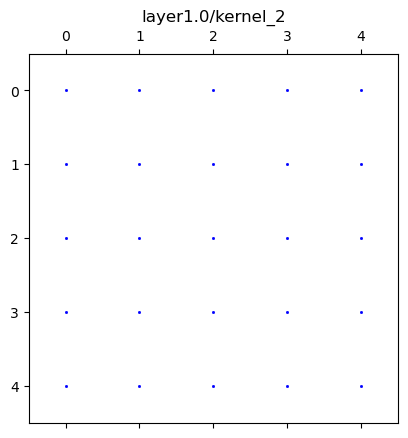

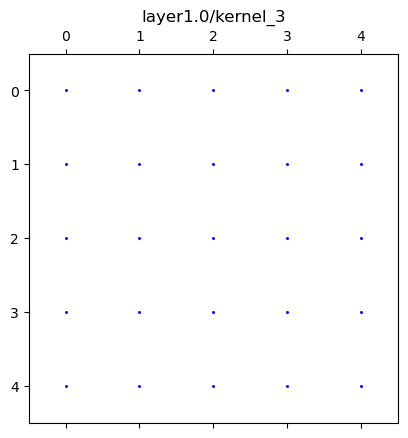

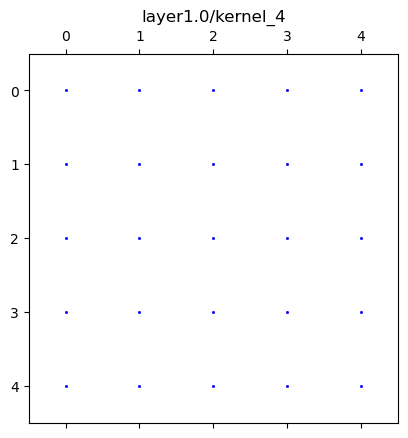

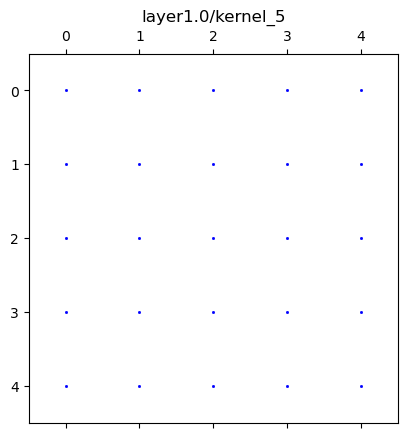

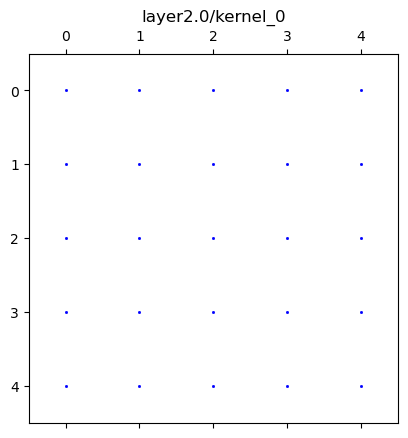

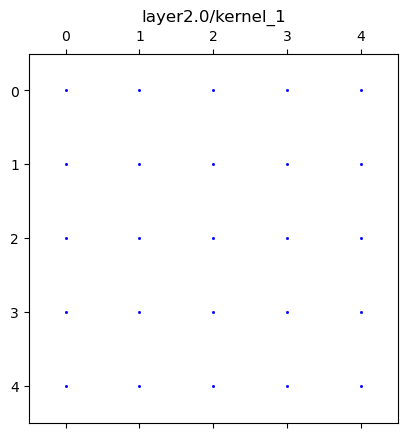

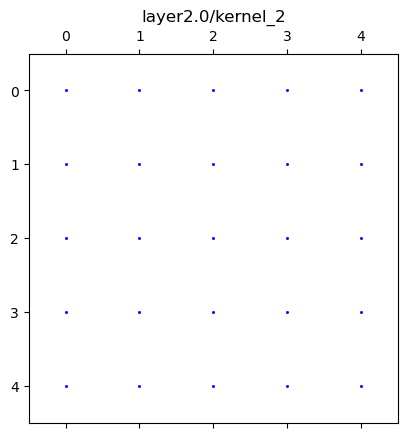

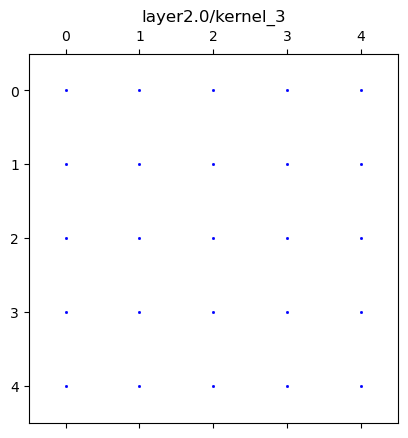

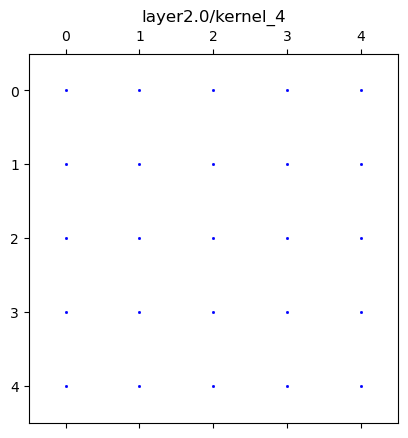

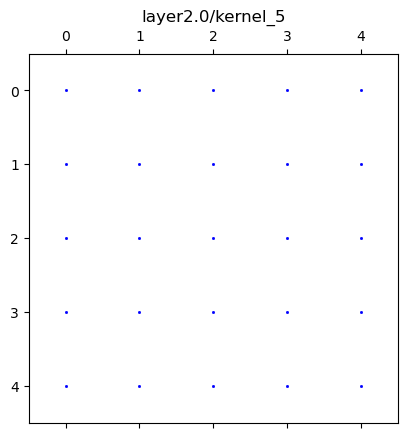

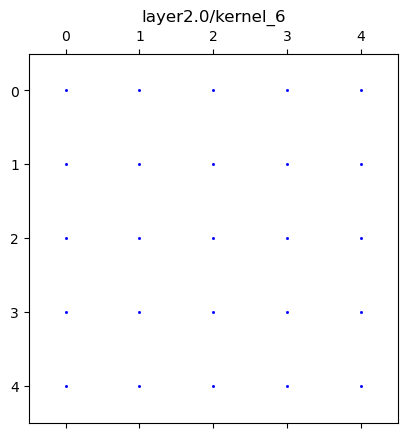

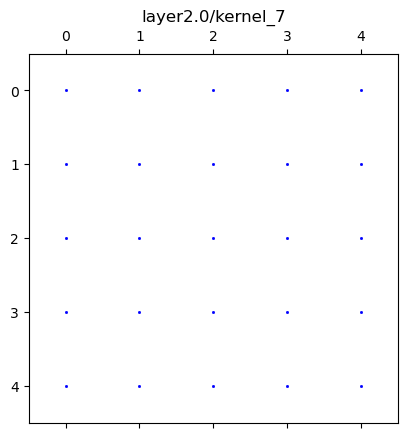

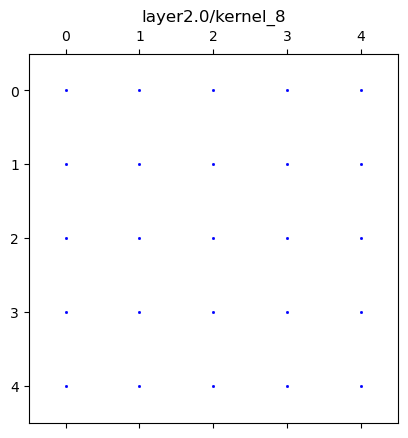

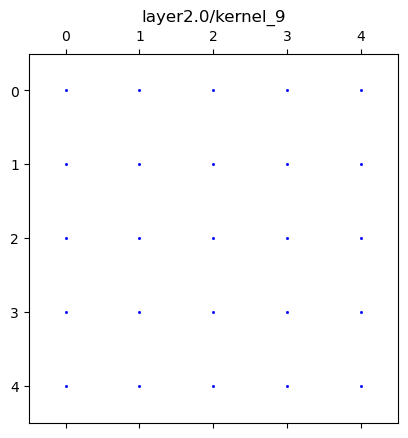

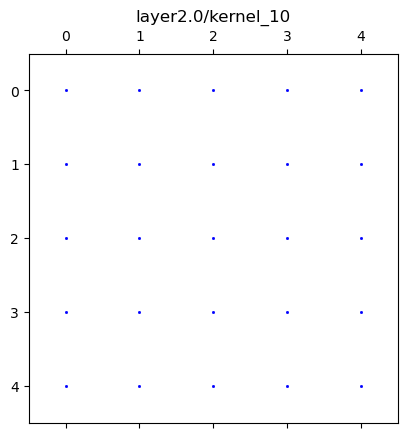

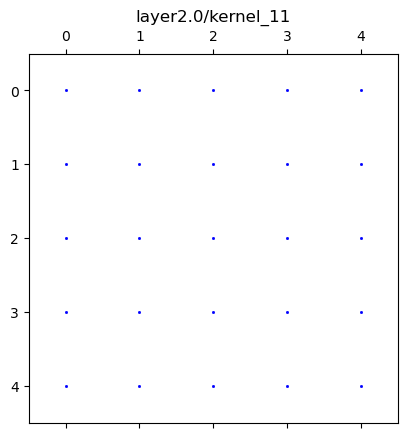

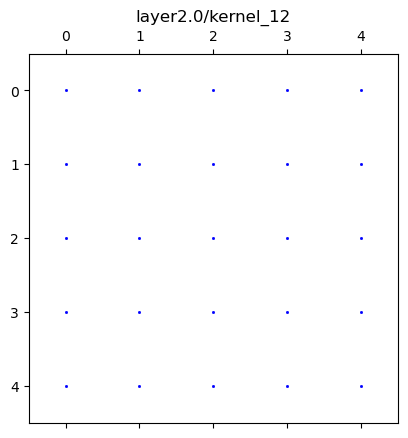

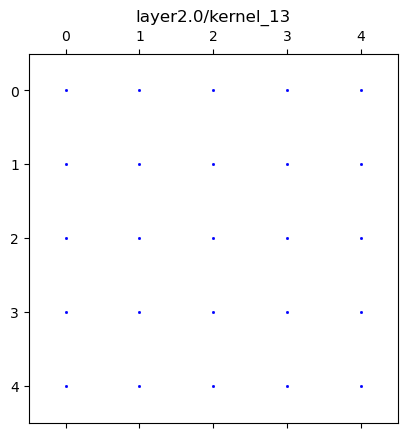

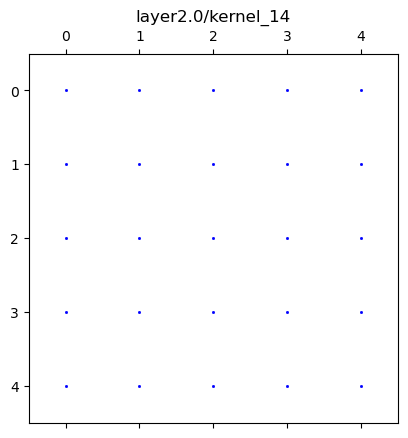

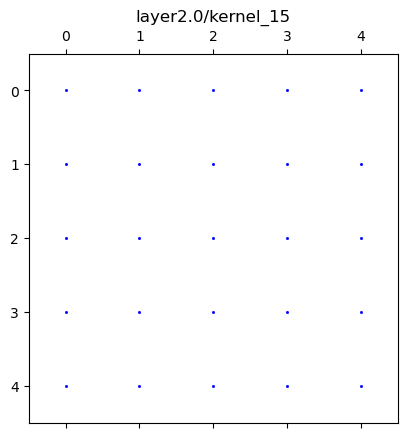

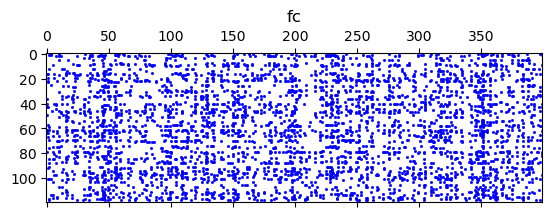

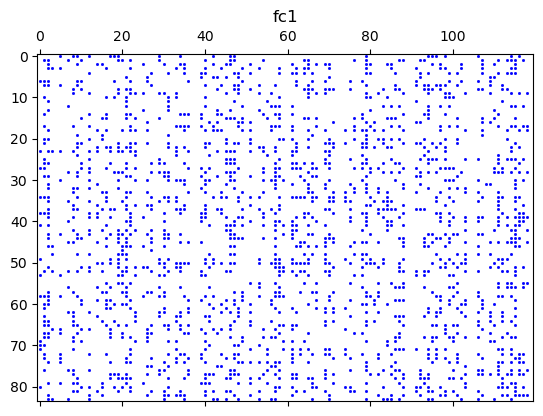

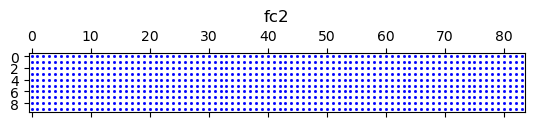

In [ ]:
net = LeNet5(10)
net.load_state_dict(torch.load('../checkpoints/mnist-lenet5.pth'))
net.to(DEVICE)

# prune each layer using a different sparsity level
conv1_pruned, _ = sparsity_prune_module(net.layer1[1],'weight',S1)
conv2_pruned, _ = sparsity_prune_module(net.layer2[1],'weight',S2)
fc1_pruned, _ = sparsity_prune_module(net.fc,'weight',S3)
fc2_pruned, _ = sparsity_prune_module(net.fc1,'weight',S4)
writer = SummaryWriter('../runs/notebooks/lenet300-100-pruned/%s' % TIMESTAMP)

total_weights = count_nonzero_weights(net)
compression = total_weights / (total_weights-(fc1_pruned+fc2_pruned))

# evaluate accuracy after pruning
loss, acc1, acc5 = evaluate(net,valid_loader,DEVICE,loss_fn)

print('Total compression factor: %.1f (%.2f%% retained weights) | top-1 Accuracy after pruning: %.3f%%' % (
        compression,1/compression*100,acc1))

writer.add_hparams({'epochs':EPOCHS,'learning rate':LR,'weight decay':WD},{'validation accuracy':acc1,'compression':compression})

plot_sparsity_matrix(net)


In [ ]:
optimizer = optim.AdamW(net.parameters(), lr=LR,weight_decay=WD)
writer = SummaryWriter('../runs/notebooks/mnist-lenet5-retrained/%s' % TIMESTAMP)

train_acc, val_acc = training_loop(EPOCHS,net,optimizer,DEVICE,train_loader,test_loader,loss_fn,100,
                                         None,'../checkpoints/mnist-lenet5-retrained.pth',writer)

writer.add_hparams({'epochs':EPOCHS,'learning rate':LR,'weight decay':WD},{'train_accuracy':train_acc,'validation accuracy':val_acc,'compression':compression})

500it [00:15, 32.14it/s, acc1=86.3, acc5=99, batch=400, loss=0.494]                           


Epoch: 001/020 | Train accuracy: 86.64% | Validation accuracy: 94.01% | Train loss: 0.480| Validation loss: 0.190| Best Validation (Ep. 001): 94.01%


500it [00:15, 31.91it/s, acc1=94.5, acc5=99.9, batch=400, loss=0.177]                         


Epoch: 002/020 | Train accuracy: 94.54% | Validation accuracy: 95.43% | Train loss: 0.176| Validation loss: 0.146| Best Validation (Ep. 002): 95.43%


500it [00:15, 31.67it/s, acc1=95.5, acc5=99.9, batch=400, loss=0.143]                         


Epoch: 003/020 | Train accuracy: 95.51% | Validation accuracy: 96.32% | Train loss: 0.142| Validation loss: 0.121| Best Validation (Ep. 003): 96.32%


500it [00:15, 32.89it/s, acc1=96.1, acc5=99.9, batch=400, loss=0.124]                         


Epoch: 004/020 | Train accuracy: 96.07% | Validation accuracy: 96.52% | Train loss: 0.123| Validation loss: 0.113| Best Validation (Ep. 004): 96.52%


500it [00:15, 32.92it/s, acc1=96.5, acc5=99.9, batch=400, loss=0.111]                         


Epoch: 005/020 | Train accuracy: 96.47% | Validation accuracy: 96.51% | Train loss: 0.111| Validation loss: 0.110| Best Validation (Ep. 004): 96.52%


500it [00:15, 32.22it/s, acc1=96.8, acc5=99.9, batch=400, loss=0.102]                         


Epoch: 006/020 | Train accuracy: 96.76% | Validation accuracy: 96.77% | Train loss: 0.102| Validation loss: 0.101| Best Validation (Ep. 006): 96.77%


500it [00:15, 33.25it/s, acc1=96.9, acc5=99.9, batch=400, loss=0.096]                          


Epoch: 007/020 | Train accuracy: 96.94% | Validation accuracy: 97.01% | Train loss: 0.096| Validation loss: 0.095| Best Validation (Ep. 007): 97.01%


500it [00:15, 31.51it/s, acc1=97.1, acc5=100, batch=400, loss=0.0904]                         


Epoch: 008/020 | Train accuracy: 97.16% | Validation accuracy: 97.01% | Train loss: 0.090| Validation loss: 0.091| Best Validation (Ep. 007): 97.01%


500it [00:15, 32.13it/s, acc1=97.2, acc5=100, batch=400, loss=0.0855]                          


Epoch: 009/020 | Train accuracy: 97.25% | Validation accuracy: 97.24% | Train loss: 0.085| Validation loss: 0.089| Best Validation (Ep. 009): 97.24%


500it [00:15, 31.89it/s, acc1=97.4, acc5=100, batch=400, loss=0.0819]                          


Epoch: 010/020 | Train accuracy: 97.43% | Validation accuracy: 97.38% | Train loss: 0.082| Validation loss: 0.089| Best Validation (Ep. 010): 97.38%


500it [00:15, 33.03it/s, acc1=97.5, acc5=100, batch=400, loss=0.0792]                          


Epoch: 011/020 | Train accuracy: 97.47% | Validation accuracy: 97.05% | Train loss: 0.079| Validation loss: 0.094| Best Validation (Ep. 010): 97.38%


500it [00:15, 32.24it/s, acc1=97.6, acc5=100, batch=400, loss=0.0764]                          


Epoch: 012/020 | Train accuracy: 97.55% | Validation accuracy: 97.14% | Train loss: 0.077| Validation loss: 0.090| Best Validation (Ep. 010): 97.38%


500it [00:15, 31.64it/s, acc1=97.7, acc5=100, batch=400, loss=0.0739]                         


Epoch: 013/020 | Train accuracy: 97.67% | Validation accuracy: 97.30% | Train loss: 0.074| Validation loss: 0.085| Best Validation (Ep. 010): 97.38%


500it [00:15, 32.64it/s, acc1=97.8, acc5=100, batch=400, loss=0.0724]                         


Epoch: 014/020 | Train accuracy: 97.79% | Validation accuracy: 97.27% | Train loss: 0.072| Validation loss: 0.085| Best Validation (Ep. 010): 97.38%


500it [00:15, 32.36it/s, acc1=97.8, acc5=100, batch=400, loss=0.0698]                         


Epoch: 015/020 | Train accuracy: 97.83% | Validation accuracy: 97.50% | Train loss: 0.070| Validation loss: 0.083| Best Validation (Ep. 015): 97.50%


500it [00:15, 32.33it/s, acc1=97.8, acc5=100, batch=400, loss=0.0689]                         


Epoch: 016/020 | Train accuracy: 97.78% | Validation accuracy: 97.62% | Train loss: 0.069| Validation loss: 0.080| Best Validation (Ep. 016): 97.62%


500it [00:15, 32.44it/s, acc1=97.9, acc5=100, batch=400, loss=0.0663]                         


Epoch: 017/020 | Train accuracy: 97.89% | Validation accuracy: 97.56% | Train loss: 0.067| Validation loss: 0.079| Best Validation (Ep. 016): 97.62%


500it [00:15, 32.54it/s, acc1=98, acc5=100, batch=400, loss=0.0657]                           


Epoch: 018/020 | Train accuracy: 97.96% | Validation accuracy: 97.58% | Train loss: 0.066| Validation loss: 0.080| Best Validation (Ep. 016): 97.62%


500it [00:15, 31.38it/s, acc1=98, acc5=100, batch=400, loss=0.0642]                           


Epoch: 019/020 | Train accuracy: 98.01% | Validation accuracy: 97.59% | Train loss: 0.064| Validation loss: 0.080| Best Validation (Ep. 016): 97.62%


500it [00:15, 32.18it/s, acc1=98.1, acc5=100, batch=400, loss=0.0623]                         


Epoch: 020/020 | Train accuracy: 98.10% | Validation accuracy: 97.72% | Train loss: 0.062| Validation loss: 0.076| Best Validation (Ep. 020): 97.72%
Total Training Time: 6.53 min


In [23]:
weight_histograms(writer,None,net)

## Quantization

In [10]:
net = LeNet5(10)
net.load_state_dict(torch.load('../checkpoints/mnist-lenet5.pth'))
# net.to(DEVICE)
BITS = 5
# net.to('cpu')

for name,module in net.named_modules():
    if isinstance(module,nn.Linear) or isinstance(module,nn.Conv2d):
        cluster_quantize(module,'weight',BITS)

# print(net.state_dict())

net.to(DEVICE)

optimizer = optim.AdamW(net.parameters(), lr=LR, weight_decay=WD)
# scheduler = sched.StepLR(optimizer,DECAY_STEPS,GAMMA)

writer = SummaryWriter('../runs/notebooks/lenet300-100-quantized/%s' % TIMESTAMP)

# train_acc, val_acc = training_loop(20,net,optimizer,DEVICE,train_loader,valid_loader,loss_fn,100,
#                                          writer=writer)

C:\Users\Dario\miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory 

In [9]:
for k, v in net.state_dict().items():
    print(k,v.shape)

layer1.0.bias torch.Size([6])
layer1.0.weight_centers torch.Size([32, 1])
layer1.0.weight_indices torch.Size([150])
layer1.1.weight torch.Size([6])
layer1.1.bias torch.Size([6])
layer1.1.running_mean torch.Size([6])
layer1.1.running_var torch.Size([6])
layer1.1.num_batches_tracked torch.Size([])
layer2.0.bias torch.Size([16])
layer2.0.weight_centers torch.Size([32, 1])
layer2.0.weight_indices torch.Size([2400])
layer2.1.weight torch.Size([16])
layer2.1.bias torch.Size([16])
layer2.1.running_mean torch.Size([16])
layer2.1.running_var torch.Size([16])
layer2.1.num_batches_tracked torch.Size([])
fc.bias torch.Size([120])
fc.weight_centers torch.Size([32, 1])
fc.weight_indices torch.Size([48000])
fc1.bias torch.Size([84])
fc1.weight_centers torch.Size([32, 1])
fc1.weight_indices torch.Size([10080])
fc2.bias torch.Size([10])
fc2.weight_centers torch.Size([32, 1])
fc2.weight_indices torch.Size([840])


# References
<a id="1">[1]</a> Han, Song, Huizi Mao, and William J. Dally. "Deep compression: Compressing deep neural networks with pruning, trained quantization and huffman coding." arXiv preprint arXiv:1510.00149 (2015).
<a id="1">[2]</a> LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.
<a id="2">[3]</a> Han, Song, et al. "Learning both weights and connections for efficient neural network." Advances in neural information processing systems 28 (2015).